**Image Segmentation**

In [12]:
# Import all libraries
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import custom_object_scope
# from niwidgets import NiftiWidget

# Define the dataset path
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/proxmed/Data/'
files = os.listdir(folder_path)

Mounted at /content/drive


In [13]:
# List all files in the folder
file_names = os.listdir(folder_path)

# Split data into training and testing sets
train_files, test_files = train_test_split(file_names, test_size=0.1, random_state=42)

print(len(train_files))
print(len(test_files))

18
3


**Pre-processing of 3D images**

In [14]:
# Min-max scaling
def normalizeImageIntensityRange(img):
  min_val = np.min(img)
  max_val = np.max(img)
  normalized_data = (img - min_val) / (max_val - min_val)
  return normalized_data

In [15]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    return normalizeImageIntensityRange(img)

In [16]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = Image.fromarray(np.uint8(img * 255))
    # resize image in (512, 512)
    img = img.resize((512, 512), Image.LANCZOS)
    fout = os.path.join(path, f'{fname}.png')
    img.save(fout)
    print(f'[+] Slice saved: {fout}', end='\r')

In [21]:
import os
import numpy as np
from multiprocessing import Pool, cpu_count

SLICE_X = True
SLICE_Y = True
SLICE_Z = False
SLICE_DECIMATE_IDENTIFIER = 3

# Slice image in one direction and save
def sliceAndSaveSlice(slice_data):
    slice_num, slice_array, slice_name, path = slice_data
    saveSlice(slice_array, f'{slice_name}-slice{str(slice_num).zfill(SLICE_DECIMATE_IDENTIFIER)}', path)

def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    slices_to_process = []

    if SLICE_X:
        print('Slicing X: ')
        for i in range(dimx):
            slices_to_process.append((i, vol[i,:,:], fname, path))

    if SLICE_Y:
        print('Slicing Y: ')
        for i in range(dimy):
            slices_to_process.append((i, vol[:,i,:], fname, path))

    if SLICE_Z:
        print('Slicing Z: ')
        for i in range(dimz):
            slices_to_process.append((i, vol[:,:,i], fname, path))

    with Pool(cpu_count()) as pool:
        pool.map(sliceAndSaveSlice, slices_to_process)

    return len(slices_to_process)



In [22]:
def imageVolumes(files):
    for folder in files:
        path = os.path.join(folder_path, folder)
        for file in sorted(os.listdir(path)):
            if "ROI" not in file:
                img = readImageVolume(os.path.join(path, file), False)
                print(file, img.shape, np.sum(img.shape), np.min(img), np.max(img))
                numOfSlices = sliceAndSaveVolumeImage(img, os.path.basename(path), imageOutput)
                print(f'\n{file}, {numOfSlices} slices created \n')


In [23]:
# Read and process image mask volumes
def imagemaskVolumes(files):
  for folder in files:
    path = os.path.join(folder_path, folder)
    for file in sorted(os.listdir(path)):
      if "ROI" in file:
        img = readImageVolume(os.path.join(path, file), False)
        # img = np.reshape(img, (256,256,1))
        print(file, img.shape, np.sum(img.shape), np.min(img), np.max(img))
        numOfSlices = sliceAndSaveVolumeImage(img, os.path.basename(path), imagemaskOutput)
        print(f'\n{file}, {numOfSlices} slices created \n')

In [24]:
# Create a file for saving the image and mask for train
imageOutput = '/content/train/img/img'
os.makedirs(imageOutput, exist_ok=True)
imagemaskOutput = '/content/train/mask/img'
os.makedirs(imagemaskOutput, exist_ok=True)

# Process image and  mask for trianing files
imageVolumes(train_files)
imagemaskVolumes(train_files)

P003.nii.gz (512, 512, 283) 1307 0.0 1.0
512 512 283
Slicing X: 
Slicing Y: 

P003.nii.gz, 1024 slices created 

N029.nii.gz (512, 512, 659) 1683 0.0 1.0
512 512 659
Slicing X: 
Slicing Y: 

N029.nii.gz, 1024 slices created 

N028.nii.gz (512, 512, 605) 1629 0.0 1.0
512 512 605
Slicing X: 
Slicing Y: 

N028.nii.gz, 1024 slices created 

N002.nii.gz (512, 512, 615) 1639 0.0 1.0
512 512 615
Slicing X: 
Slicing Y: 

N002.nii.gz, 1024 slices created 

N035.nii.gz (512, 512, 624) 1648 0.0 1.0
512 512 624
Slicing X: 
Slicing Y: 

N035.nii.gz, 1024 slices created 

Anon3.nii.gz (512, 512, 119) 1143 0.0 1.0
512 512 119
Slicing X: 
Slicing Y: 

Anon3.nii.gz, 1024 slices created 

N004.nii.gz (512, 512, 123) 1147 0.0 1.0
512 512 123
Slicing X: 
Slicing Y: 

N004.nii.gz, 1024 slices created 

N001.nii.gz (512, 512, 633) 1657 0.0 1.0
512 512 633
Slicing X: 
Slicing Y: 

N001.nii.gz, 1024 slices created 

P012.nii.gz (512, 512, 421) 1445 0.0 1.0
512 512 421
Slicing X: 
Slicing Y: 

P012.nii.gz, 102

In [25]:
# Create a file for saving the image and mask for validation
imageOutput = '/content/test/img/img'
os.makedirs(imageOutput, exist_ok=True)
imagemaskOutput = '/content/test/mask/img'
os.makedirs(imagemaskOutput, exist_ok=True)

# Process image and  mask for testing files
imageVolumes(test_files)
imagemaskVolumes(test_files)

P017.nii.gz (512, 512, 421) 1445 0.0 1.0
512 512 421
Slicing X: 
Slicing Y: 

P017.nii.gz, 1024 slices created 

N003.nii.gz (512, 512, 682) 1706 0.0 1.0
512 512 682
Slicing X: 
Slicing Y: 

N003.nii.gz, 1024 slices created 

Anon10.nii.gz (512, 512, 665) 1689 0.0 1.0
512 512 665
Slicing X: 
Slicing Y: 

Anon10.nii.gz, 1024 slices created 

P017_ROI.nii.gz (512, 512, 421) 1445 0.0 1.0
512 512 421
Slicing X: 
Slicing Y: 

P017_ROI.nii.gz, 1024 slices created 

N003_ROI.nii.gz (512, 512, 682) 1706 0.0 1.0
512 512 682
Slicing X: 
Slicing Y: 

N003_ROI.nii.gz, 1024 slices created 

Anon10_ROI.nii.gz (512, 512, 665) 1689 0.0 1.0
512 512 665
Slicing X: 
Slicing Y: 

Anon10_ROI.nii.gz, 1024 slices created 



In [26]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 16

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir_train_image = '/content/train/img'
data_dir_train_mask = '/content/train/mask'
data_dir_test_image = '/content/test/img'
data_dir_test_mask = '/content/test/mask'

NUM_TRAIN = 16384
NUM_TEST = 5120

NUM_OF_EPOCHS = 10

In [27]:
# Data agumentation for training images and mask
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    img_datagen = ImageDataGenerator(
        rescale=1./255)
        # rotation_range=90,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # zoom_range=0.3)

    img_generator = img_datagen.flow_from_directory(
        img_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        seed=SEED)
    msk_generator = img_datagen.flow_from_directory(
        msk_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        seed=SEED)

    return zip(img_generator, msk_generator)

In [28]:
# Data agumentation for testing images and mask
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    img_datagen = ImageDataGenerator(rescale=1./255)

    img_generator = img_datagen.flow_from_directory(
        img_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        seed=SEED)
    msk_generator = img_datagen.flow_from_directory(
        msk_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        seed=SEED)

    return zip(img_generator, msk_generator)

In [29]:
# Call the traing images
train_generator = create_segmentation_generator_train(
    data_dir_train_image,
    data_dir_train_mask,
    BATCH_SIZE_TRAIN)

# Call the testing images
test_generator = create_segmentation_generator_test(
    data_dir_test_image,
    data_dir_test_mask,
    BATCH_SIZE_TEST)

Found 9216 images belonging to 1 classes.
Found 9216 images belonging to 1 classes.
Found 1536 images belonging to 1 classes.
Found 1536 images belonging to 1 classes.


In [30]:
# Display image after agumentation
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [31]:
# Display image, True mask and Predicted mask from test_generator
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

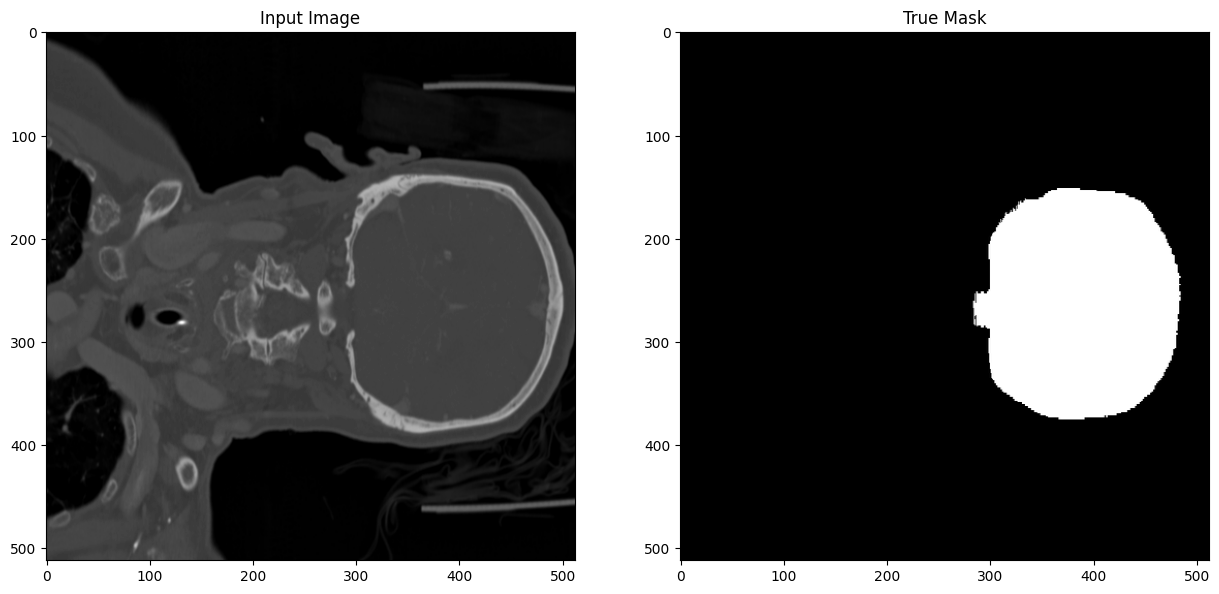

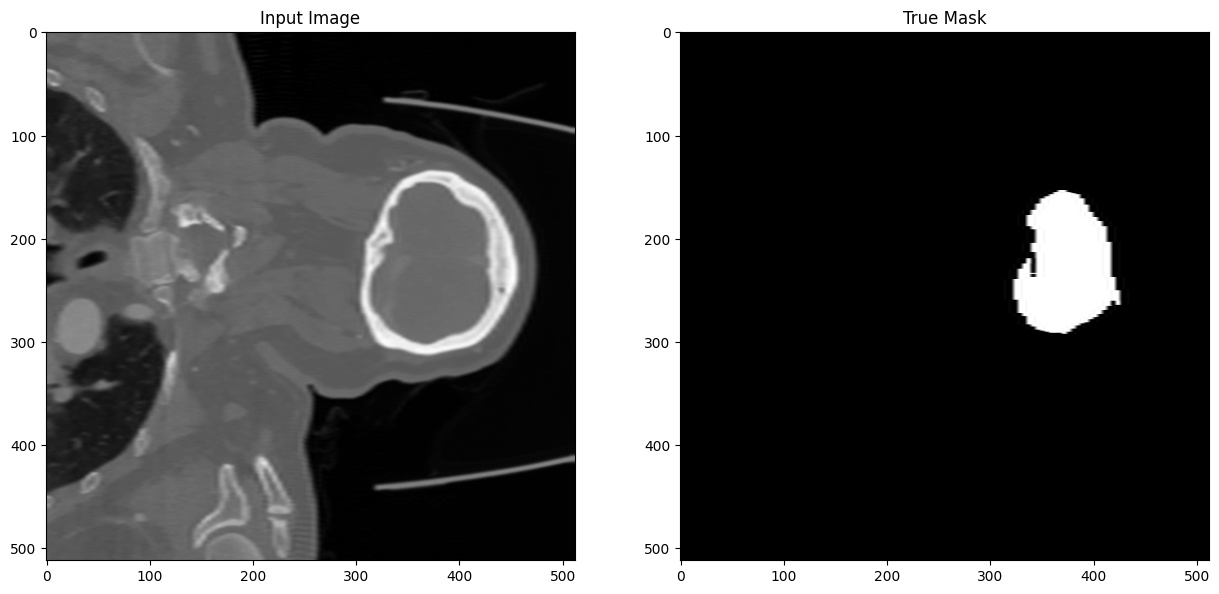

In [32]:
show_dataset(train_generator, 2)

**Training the dataset**

In [33]:
# Defining Unet model from scratch
def unet(n_levels, initial_features=8, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')

    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            if _ == 0:
                x = keras.layers.Dropout(0.25)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.Normalization()(x)
            x = keras.layers.MaxPool2D(pooling_size)(x)

    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Normalization()(x)
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)

    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)

    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

# Defining dice loss for image segmantation
def dice_loss(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice_loss = 1.0 - (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
    return dice_loss

In [34]:

# define constants
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST
num_classes = 2
mean_iou = MeanIoU(num_classes=num_classes)
model = unet(5)
model.compile(optimizer='adam', loss=dice_loss, metrics=[mean_iou])

In [35]:
# Summary of overall model
model.summary()

Model: "UNET-L5-F8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 8)  584         ['dropout[0][0]']       

In [36]:
# Train the model
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=EPOCH_STEP_TRAIN,
    validation_data=test_generator,
    validation_steps=EPOCH_STEP_TEST,
    epochs=NUM_OF_EPOCHS)


<ipython-input-36-faa3c858f88b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
1024/1024 [==============================] - 498s 462ms/step - loss: 0.7607 - mean_io_u: 0.7096 - val_loss: 0.7329 - val_mean_io_u: 0.6593
Epoch 2/10
1024/1024 [==============================] - 472s 461ms/step - loss: 0.5175 - mean_io_u: 0.9410 - val_loss: 0.4131 - val_mean_io_u: 0.8671
Epoch 3/10
1024/1024 [==============================] - 471s 460ms/step - loss: 0.2825 - mean_io_u: 0.9660 - val_loss: 0.2038 - val_mean_io_u: 0.9567
Epoch 4/10
1024/1024 [==============================] - 470s 459ms/step - loss: 0.1737 - mean_io_u: 0.9533 - val_loss: 0.3646 - val_mean_io_u: 0.6976
Epoch 5/10
1024/1024 [==============================] - 472s 461ms/step - loss: 0.1209 - mean_io_u: 0.9481 - val_loss: 0.4439 - val_mean_io_u: 0.6531
Epoch 6/10
1024/1024 [==============================] - 472s 461ms/step - loss: 0.0901 - mean_io_u: 0.9490 - val_loss: 0.2852 - val_mean_io_u: 0.7843
Epoch 7/10
1024/1024 [==============================] - 472s 461ms/step - loss: 0.0486 - mean_io_u: 

**Note:**
>>**Loss used in this model is dice loss**

**Model Statistics**
>> Dice Loss: 0.0502 <br>
>> Dice Score: 1 - Dice Loss -> 94.98 <br>
>> Mean IoU: 95.03

In [37]:
# Save the model as an HDF5 file
model.save(f'UNET-BRAINCTA_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [38]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

1/1 [==============================] - 0s 43ms/step


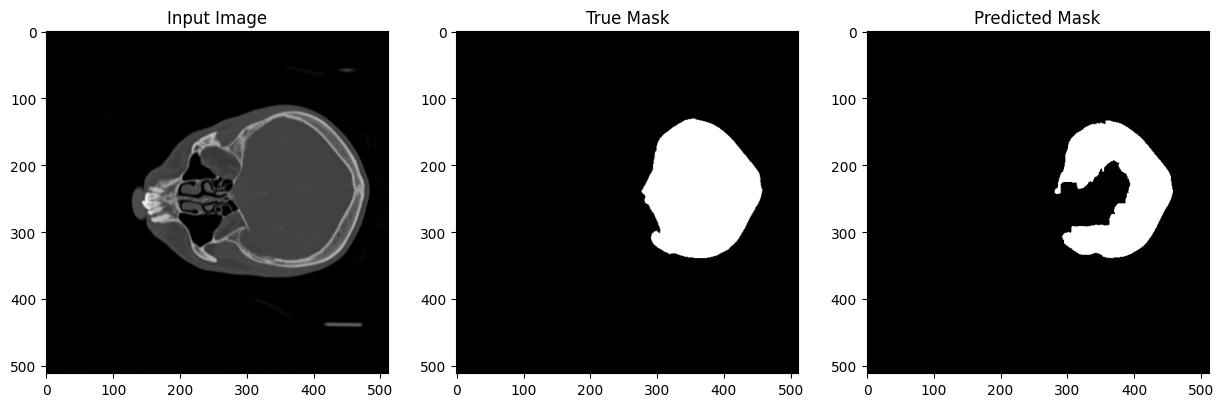

1/1 [==============================] - 0s 55ms/step


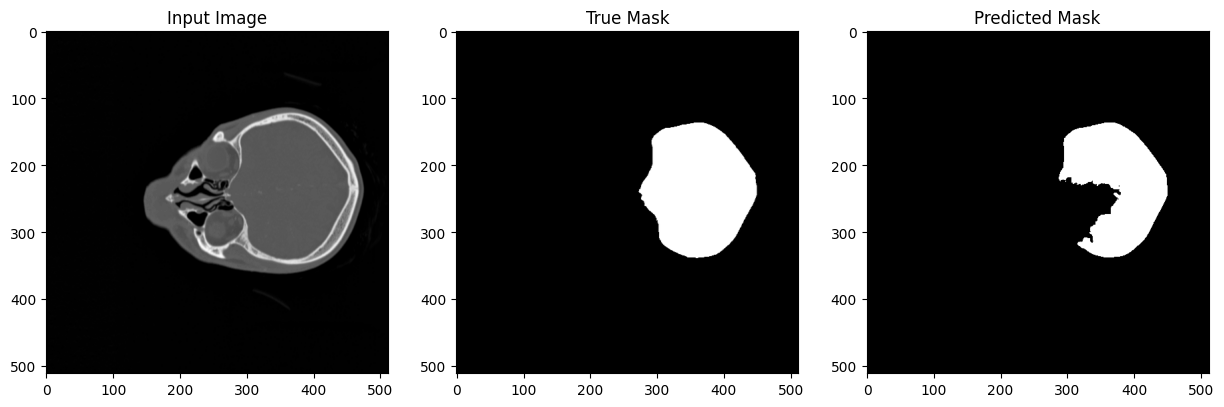

1/1 [==============================] - 0s 30ms/step


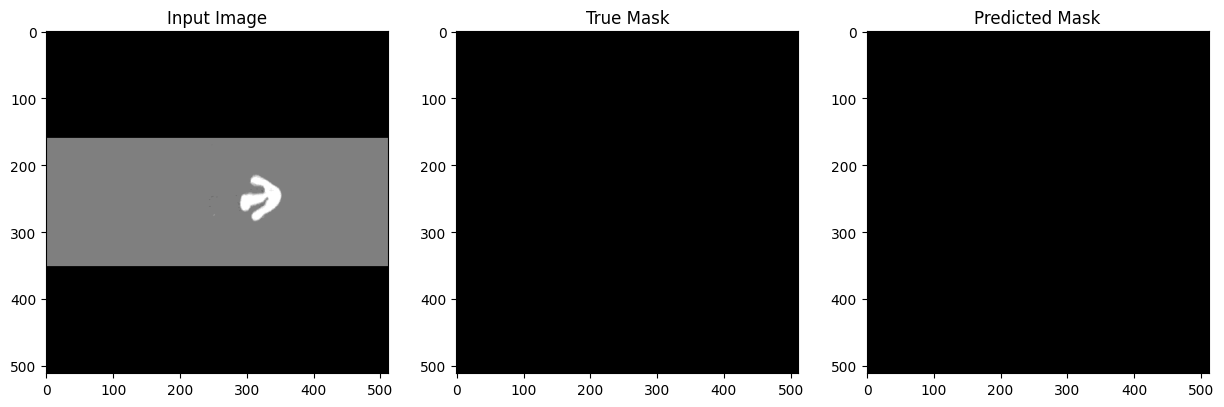

1/1 [==============================] - 0s 32ms/step


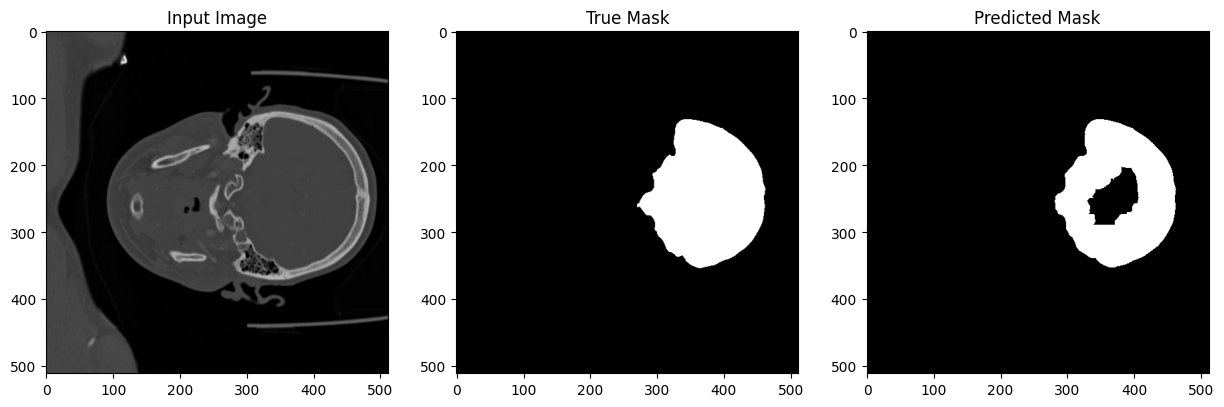

In [40]:
show_prediction(test_generator, 4)

In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

In [47]:
# Define constants
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

# For single slicing prediction
sliceIndex = 24

In [42]:
# Min-max scaling
def normalizeImageIntensityRange(img):
  min_val = np.min(img)
  max_val = np.max(img)
  normalized_data = (img - min_val) / (max_val - min_val)
  return normalized_data

In [53]:
def dice_loss(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice_loss = 1.0 - (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
    return dice_loss

In [48]:
# Pick any image
targetName = 'N002'
targetImagePath = f'/content/drive/My Drive/proxmed/Data/{targetName}/{targetName}.nii.gz'
targetMaskPath  = f'/content/drive/My Drive/proxmed/Data/{targetName}/{targetName}_ROI.nii.gz'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [55]:

# Load the model
with custom_object_scope({'dice_loss': dice_loss}):
  model = load_model(f'UNET-BRAINCTA_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [56]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

**Single Slicing Prediction**

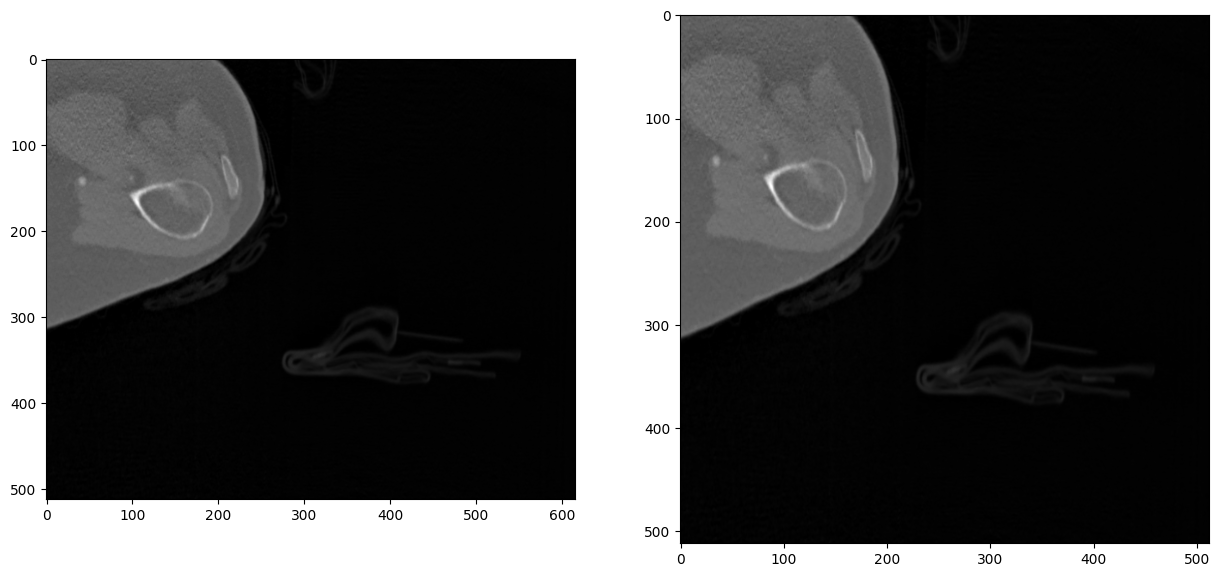

((512, 615), (512, 512))

In [57]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[sliceIndex,:,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

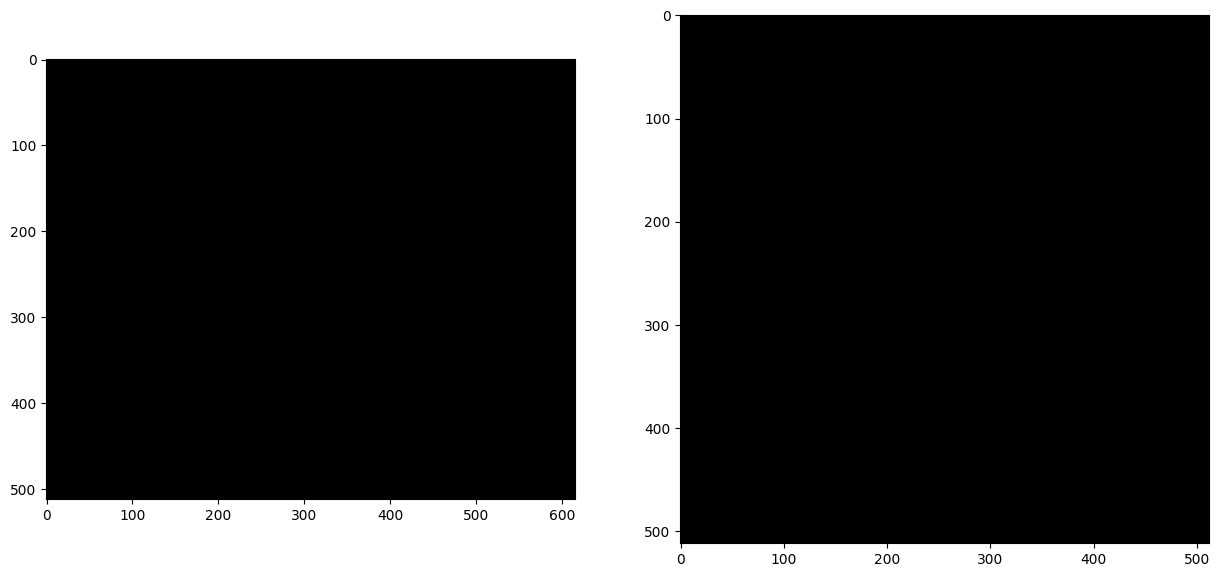

((512, 615), (512, 512))

In [58]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[sliceIndex,:,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

1/1 [==============================] - 1s 1s/step


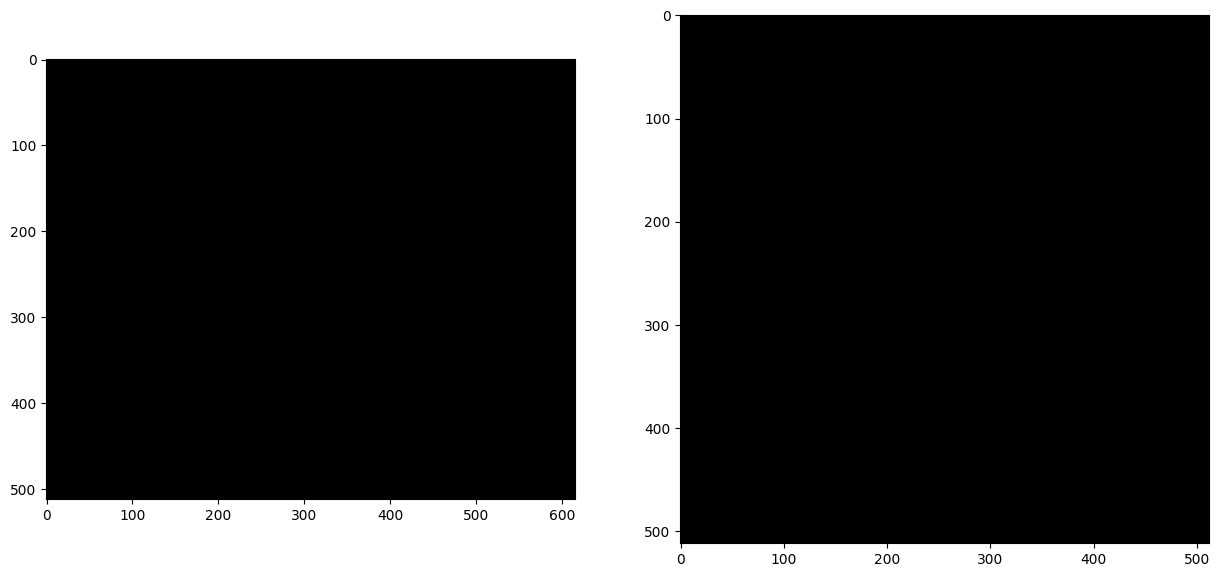

((512, 615), (512, 512))

In [59]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

**Prediction of full volume**

In [60]:
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

# Slice image in all directions
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape

    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))

    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)

    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [61]:
predImg = predictVolume(imgTarget)

1/1 [==============================] - 0s 34ms/step


In [62]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

NameError: ignored

In [ ]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

In [ ]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

In [4]:
!pip3 install cmake

In [6]:
!sudo apt-get install gcc libpq-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gcc is already the newest version (4:11.2.0-1ubuntu1).
gcc set to manually installed.
libpq-dev is already the newest version (14.9-0ubuntu0.22.04.1).
libpq-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [8]:
!sudo apt-get install python-dev  python-pip -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python2-dev python2 python-dev-is-python3

E: Package 'python-dev' has no installation candidate


In [9]:
!pip3 install wheel setuptools --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.1/805.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [10]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [64]:
pip install niwidgets

  Using cached niwidgets-0.2.2-py3-none-any.whl (12.5 MB)
  Using cached ipyvolume-0.5.2-py2.py3-none-any.whl (2.9 MB)
  Using cached nibabel-2.5.1-py3-none-any.whl (3.3 MB)
  Using cached nilearn-0.5.2-py2.py3-none-any.whl (2.3 MB)
  Using cached scikit-learn-0.20.4.tar.gz (11.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached traittypes-0.2.1-py2.py3-none-any.whl (8.6 kB)
  Using cached ipywebrtc-0.6.0-py2.py3-none-any.whl (260 kB)
  Using cached pythreejs-2.4.2-py3-none-any.whl (3.4 MB)
  Obtaining dependency information for jedi>=0.16 from https://files.pythonhosted.org/packages/8e/46/7e3ae3aa2dcfcffc5138c6cef5448523218658411c84a2000bf75c8d3ec1/jedi-0.19.0-py2.py3-none-any.whl.metadata
  Using cached jedi-0.19.0-py2.py3-none-any.whl.metadata (22 kB)
  Obtaining dependency information for ipydatawidgets>=1.1.1 from https://files.pythonhosted.org/packages/f1/5b/e63c877c4c94382b66de5045e08ec8cd960e8a4d22f0d62a4dfb1f9e5ac6/ipydatawidgets-4.3.5-py2.py3-none-any.whl.metadata
 